# Task 1:
**Go through examples of  Chapter 3 of Geron book, and submit one jupyter notebook (HW3a.ipynb) with your own notes that have example code snippets for each task with the MNIST dataset. (20 points)**

## Chapter 3: Classification

## MNIST dataset

The "hello world" of machine learning. This dataset is a collection of 70k small images of handwritten numbers. Scikit-Learn has many helper functions to download popular datasets. MNIST is one of them.

In [2]:
# fetch MNIST dataset from OpenML.org
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

The ```fetch_openml()``` function returns inputs as a Pandas dataframe. The MNIST dataset contains images, so dataframes aren't idea. Instead we set ```as_frame=False``` to return the data as NumPy arrays instead.

In [27]:
# save the data and targets to separate variables
X, y = mnist.data, mnist.target

In [28]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
X.shape

(70000, 784)

In [30]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [31]:
y.shape

(70000,)

There are 70k images and each image has 784 features. Each image is 28 x 28 pixels, and each feature represents one pixel's intensity, from 0 (white) to 255 (black). For example, we can take a look at one digit in the dataset:

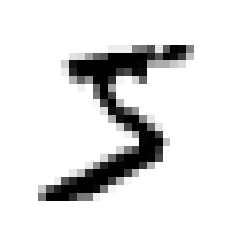

In [32]:
import matplotlib.pyplot as plt

# grab an instance's feature vector.
def plot_digit(image_data):
    
    # reshape feature vector into a 28 x 28 array
    image = image_data.reshape(28, 28)
    
    # cmap="binary" gives a grayscale colormap
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
some_digit = X[0]
plot_digit(some_digit)
plt.show()

This looks like a 5, and the label agrees:

In [33]:
y[0]

'5'

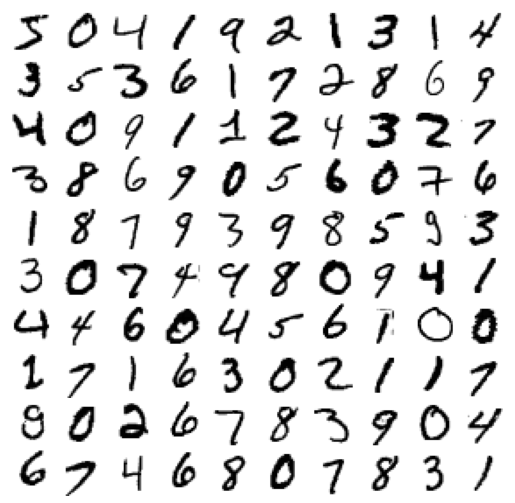

In [34]:
# here's some more instances from MNIST
plt.figure(figsize=(9, 9))

for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Note: You should always create a test set and set it aside before inspecting the data closely. The MNIST dataset returned by ```fetch_openml()``` is already split into a training set (first 60k images) and a test set (last 10k images).

In [37]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled. This is good because guarantees that all cross-validation folds will be similar (it would be unproductive if a fold were missing some digits). Additionally, some ML algorithms are sensitive to the order of the training instances and perform poorly if they get many similar instances in a row. Shuffling the dataset lowers the probability of this happening.

## Training a Binary Classifier

Let's simplify the problem: we will try to identify one digit, e.g. the number 5, instead of all numbers. A *binary classifier* is capable of distinguishing between just two classes. In this case the two classes are ```5``` and ```not 5```.

First we'll create the target vectors for this task:

In [38]:
y_train_5 = (y_train == '5') # True if 5, else False
y_test_5 = (y_test == '5')

Now we'll pick a classifier and train it. A good place to start is with a *stochastic gradient descent* (SGD), using SKL's ```SGDClassifier``` class. 

We'll create an ```SGDClassifier``` and train it on the whole training set:

In [39]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now let's use the SGDClassifier model to detect which images are the number 5:

In [40]:
sgd_clf.predict([some_digit]) # some_digit == X[0]

array([ True])

The model is right in classifying the first image. After fitting, it is time to measure performance.

## Performance Measures

Evaluating a classifier usually more tricky than evaluiating a regressor. There are many performance measures available.

### Measuring Accuracy using Cross-Validation

This is way to evaluate both a regressor model and a classifier model. Just like with a regression model, we will use the ```cross_val_score()``` function to evaluate our ```SGDClassifier``` model using k-fold cross-validation with three folds. 

In [41]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Above 95% accuracy on all cross-validation folds is a bit unbelievable. Let's look at a dummy classifier that just classifies every single image in the most frequent class, which is the negative class in this case, i.e., ```not 5```:

In [42]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

# print True is there are any 5s detected
print(any(dummy_clf.predict(X_train)))

False


In [43]:
# check this model's accuracy
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

Over 90% accuracy? This is because only about 10% of the images are 5s, so if you always guess that an image is ```not 5```, you will be right about 90% of the time. 

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when dealing with *skewed datasets*. A much better way to evaluate the performance of a classifier is to look at its *confusion matrix* (CM).

### Confusion Matrices

The general idea of a confusion matrix is to count the number of times instances of class A are classified as class B, for all A/B pairs. For example, to find the number of times the classifier confused the images of 8s with 0s, look at row #8, column #0 of the confusion matrix.

To compute the confusion matrix, first you need a set of predictions to be compared to the actual targets. Do not make predictions on the test set until the very end of the project. Use a validation set or use the ```cross_val_predict()``` function:

In [44]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Similar to ```cross_val_score()```, ```cross_val_predict()``` performs k-fold cross-validation, but instead of returning the evaluation score, it returns the predictions made on each test fold. This methods means we get a clean prediction for each instance in the train set, i.e., the model makes predictions on data that it never saw during training.

Now we can get the confusion matrix using the ```confusion_matrix()``` function:

In [46]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an *actual class*, while each column represents a *predicted class*. The first row of this matrix considers ```not 5``` images (the *negative class*): 53,892 images were correctly classified as ```not 5```, these are *true negatives*. The remaining 687 were wrongly classified as ```5```, these are *false positives* or *type I errors*. The second row considers ```5``` images (the *positive class*): 18,91 were wrongly classified as ```not 5```, these are *false negatives* or *type II errors*. The  renaining  3,530 were correctly classified  as ```5```,  these are *true  positives*. A erfect  classifier's confusion matrix would  only  have non-zero  values on its main diagonal.

While the confusion matrix gives a lot of information, sometimes a more concise metric may be better. One example would be to look at the accuracy of the positive predictions, i.e., the *precision* of the classifier.

$\text{precision}=\frac{TP}{TP+FP}\$

- TP: true positives
- FP: false positives

Since precision only looks at the *positive class* (the second row), it is typically used along with another metric called *recall* or *sensitivity*. Recall is the ratio of positive instances taht are correctly detected by the classifier.

$\text{recall}=\frac{TP}{TP+FN}$
- TP: true positives
- FN: false negatives

### Precision and Recall

SKL provides functions to compute classifier metrics, including precision and recall:

In [49]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

In [50]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.6511713705958311

The 5-classifier now does not look as good as it did when we only looked at its accuracy. When it claims an image represents a 5, it is correct only 83.7% of the time. In addition, it only detects 65.1% of the 5s.

Precision and recall are often combined into a single metric called the *$F_1$ score*, especially when you need a single metric to compare between two classifiers. The $F_1$ score is the *harmonic mean* of precision and recall. The harmonic mean gives more weight to low values and as a result, the classifier will only get a high $F_1$ score if both recall and precision are high.

$F_1 = \frac{2*\text{precision}*\text{Recall}}{\text{precision}+\text{recall}} =\frac{2*TP}{2*TP+FP+FN}$
    
To compute the $F_1$ score, call the ```f1_score()``` function:

In [51]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

$F_1$ score favors classifiers with similar precision and recall, but depending on the context, you might only really care about one or the other. E.g., a malignent tumor detector should prioritize precision over all else.  Unfortunately, you can't have both high precision and high recall past a certain threshold. There is a *precision/recall trade-off*.

### The Precision/Recall Trade-off

Let’s look at how the ```SGDClassifier``` makes its classification decisions. For each instance, it computes a score based on a *decision function*. If the score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class. Raising the *decision threshold* increases precision but decreases recall. Conversely, lowering the threshold increases recall and reduces precision. (Figure 3-4 in textbook)

SKL doesn't let you set thresholds directly, but it gives you access to the decision scores it uses to make predictions. Calling the classifier's ```decision_function()``` methods will return a score for each instance. We can then use any threshold we want to make predictions based on those scores:

In [58]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [55]:
threshold = 0

y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the above code returns the same result as the ```predict()``` method.

We can raise the threshold:

In [59]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

As shown above, raising threshold decreases recall.

To decide which threshold to use, first use ```cross_val_predict()``` to get scores of all instances on the trianing set, but this time specify to return decision scores instead of predictions:

In [60]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

Now we can use ```precision_recall_curve()``` to compute precision and recall for all possible thresholds.

In [61]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, we can use Matplotlib to plot precision and recall as functions of the threshold value. Let's show the threshold of 3,000 that we selected:

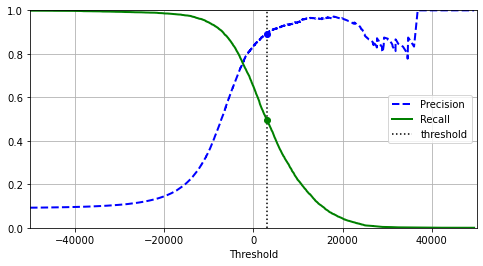

In [64]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

At a threshold value of 3,000, precision is ~90% and recall is ~50%.

Another way to select a good threshold is to plot precision against recall:

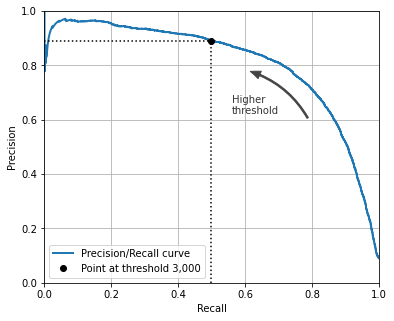

In [63]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies Figure 3-6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

Notice that precision starts to fall sharply at ~0.8 recall. Probably select a precision/recall trade-off before that drop, but the decision likely depends on the project.

If you decide to aim for 90% precision, you can use the first plot, but it won't be very precise. Alternatively, you can search for the lowest threshold that gives you 90% precision using the ```argmax()``` method on a NumPy array. This returns the first index of the maximum value, which in this case means the first True value:

In [65]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

To make predictions, instead of calling the classifier's ```predict()``` method, you can run this code:

In [66]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

Now let's check the precision and recall of the predictions:

In [67]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [69]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

Now we have a 90% precision classifier, but a high-precision classifier is not very useful if its recall is too low. For many applications, 48% recall would not be viable.

### The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The ROC curve plots the true positive rate (recall) against the false positive rate (fall-out). The false positive rate is the ratio of negative instances that are incorrectly classified as positive. It is equal to $1-\text{the true negative rate (TNR)}$. The TNR is also called *specificity*. The ROC curve plots $\text{sensitivity}$ vs $1-\text{specificity}$.

To plot the ROC curve, first use ```roc_curve()``` to compute the TPR and FPR for various thresholds:

In [70]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

And then plot FPR against TPR using Matplotlib:

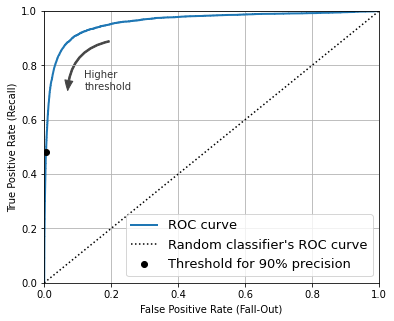

In [71]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

Again, there is a trade-off: higher recall (TPR) is correlated with more false positives (FPR). The dotted line represents a purely random classifier. A good classifier stays far from that line (toward the top left corner).

We can compare classifiers by measuring the area under the curve (AUC). For a perfect classifier, AUC = 1 and for a purely random classifier, AUC = 0.5.

In [72]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let's create a ```RandomForestClassifier```, whose PR curve and F_1 score can be compared to the ```SGDClassifier```:

In [73]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

We can call the ```cross_val_predict()``` function to train the ```RandomForestClassifier``` using cross-validation and make it predict class probabilities for every image as follows:

In [76]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

Look at the class probablilities for the first two images in the training set:

In [77]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The model predicts that the first image is positive with 89% probability, and it predicts that the second image is negative with 99% probability. 

The second column contains the estimated probabilities for the positive class, we can pass them to ```precision_recall_curve()```:

In [78]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

We can plot the PR curve now:

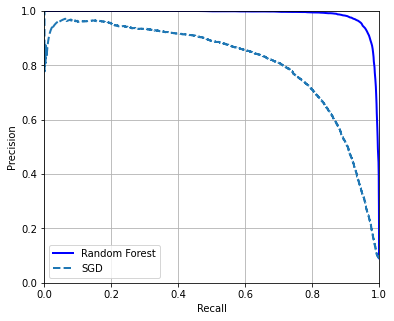

In [80]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

The ```RandomForestClassifier```'s PR curve looks much better than the ```SGDClassifier```'s: it is much closer to the top-right corner. It's $F_1$ score and ROC AUC score should also be significantly better:

In [83]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [84]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

The ```RandomForestClassifier``` also has ~99.1% precision and 86.6% recall, which is pretty good.

This covers binary classifiers. Now we can try to detect more than just 5s.

## Multiclass Classification

*Multiclass classifiers* (*multinomial classifiers*) can distinguish between more than  two classes.

Some Scikit-Learn classifiers (e.g., LogisticRegression, RandomForestClassifier, and GaussianNB) are capable of handling multiple classes natively. Others are strictly binary classifiers (e.g., SGDClassifier and SVC). However, using various strategies, you can perform multiclass classification with multiple binary classifiers.

One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit. Then when you want to classify an image, you get the decision score from each classifier for that image and select the class whose classifier outputs the highest score. This strategy is called *one-versus-the-rest*  (OvR) or *one-versus-all* (OvA).

Another way is to train a binary classifier for every pair of digits. This strategy is called *one-versus-one* (OvO). If there are $N$ classes, you need to train $N*\frac{(N-1)}{2}$ classifiers. The MNIST, this means trraining 45 binary classifiers and running each image you want to classify through all 45 classifiers. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set containing the two classes that it must distinguish.

Some algorithms scale poorly with training set size. For these algs, OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algs, however, OvR is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. We can try this with a support vector machine classifier using the ```sklrean.svm.SVC``` class (training only the first 2,000 images for the sake of time):

In [85]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5

SVC(random_state=42)

Since there are more than 2 classes, SKL used the OvO strategy and trained 45 binary classifiers. 

Now we can make a prediction:

In [86]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

This is correct! If you call the ```decision_function()``` method, you will see that it returns 10 scores per instance: one per class. Each class gets a score equal to the number of won duels plus or minus a small tweak to break ties.

In [87]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

The highest score is 9.3, and from its position, we can see it's the one corresponding to class 5.

In [88]:
class_id = some_digit_scores.argmax()
class_id

5

When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value. For MNIST, class 5 happens to be at index 5, however, this is not always the case. Generally you need to look up the label like so:

In [90]:
print(svm_clf.classes_)
print(svm_clf.classes_[class_id])

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
5


If you want to force SKL to use OvO or OvR, you can use the ```OneVsOneClassifier``` or ```OneVsRestClassifier``` classes. The following code creates a multiclass classifier using the OvR strategy, based on an ```SVC```:

In [91]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

Now let's make a prediction and check the number of trained classifiers:

In [93]:
print("prediction:", ovr_clf.predict([some_digit]))
print("number of trained classifiers:", len(ovr_clf.estimators_))

prediction: ['5']
number of trained classifiers: 10


Training an SGDClassifier on a multiclass dataset and using it to make predictions is just as easy:

In [94]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

The prediction here is incorrect, but errors happen sometimes. Here, SKL used the OvR strategy under the hood. Since there are 10 classes, it trained 10 binary classifiers. 

```decision_function()``` returns one value per class. Here are the scores that the SGD classifier assigned to each class:

In [95]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

Notice almost all scores are negative. The classifier is not confident in its predictions. Ofc we should evaluate the classifier on multiple images. Again, we can use ```cross_val_score()```:

In [96]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

The model got over 85% accuracy on all test folds. A random classifier would expect 10% accuracy, so this isn't bad, but we can do better. Simply scaling the inputs increases accuracy above 89.1%:

In [103]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

After finding a promising model, you want to find ways to improve it. We can do this by analyzing the types of errors it makes.

First, look at the confusion matrix. To do this, make predictions using ```cross_val_predict()```; then pass the labels and predictions to ```confusion_matrix()```. But, since there 10 classes, the confusion matrix may be hard to interpret with only numbers.

We can make a colored diagram of the confusion matrix using ```ConfusionMatrixDisplay.from_predictions()```:

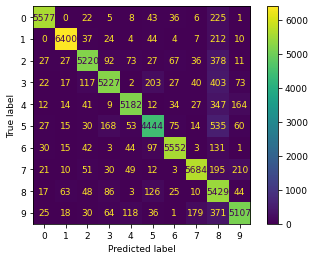

In [112]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

plt.show()

Most images are on the main diagonal of the matrix, meaning they were classified correctly. Notice that the cell on the diagonal in row #5 and column #5 is slightly darker than the other digits. This could be because the model made more errors on 5s, or because there are fewer 5s in the dataset than the other digits. To avoid confusion, we'll normalize the matrix by dividing each value by the total number of images in the corresponding (true) class (i.e., divide by the sum of each row). We can do this by setting ```normalize="true"``` and by specifying ```values_format=".0%``` to show percentages without decimals:

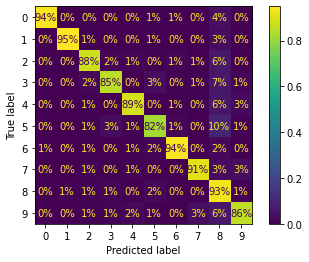

In [113]:
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")

plt.show()

Only 82% of the images of 5s were classified correctly. The model most commonly misclassified 5s as 8s. This happened for 10% of all 5s, but only 2% of all 8s were misclassified as 5s. Notice, many digits were misclassified as 8s, but this isn't immediately obvious. We can make errors stand out more by putting zero weight on correct predictions:

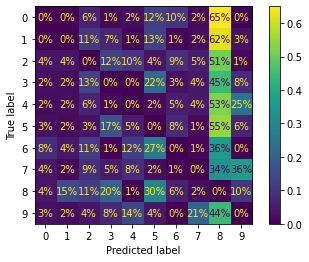

In [114]:
sample_weight = (y_train_pred != y_train)

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")

plt.show()

Now it's easier to see the kinds of errors the classifier makes. The column for class 8 is bright, confirming that many images were misclassified as 8s and this is the most common misclassification for most classes. Note: always keep in mind, this diagram is for errors only and excludes correct predictions.

We can also normalize a confusion matrix by column with ```normalize="pred"```. We can see that 56% of misclassified 7s are actually 9s:

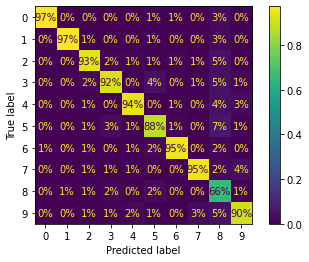

In [115]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="pred", values_format=".0%")

plt.show()

The confusion matrix can give insights into how to improve a classifier. The diagrams above indicate that we should work on reducing the number of false 8s.

By analyzing individual errors, we can gain insights into what the classifier is doing and why it is failing. E.g., let's plot examples of 3s and 5s in confusion matrix style:

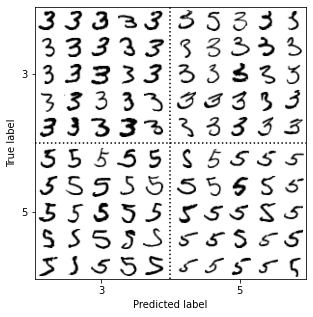

In [116]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

# extra code – this cell generates Figure 3–11
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.show()

Some digits that the classifier gets wrong are so badly written that even a human would have trouble classifying them. Most misclassified images, however, seem obvious to us. We used a simple ```SGDClassifier```, which is just a linear model. Since 3s and 5s differ by only a few pixels, this model will easily confuse them.

This classifier is very sensitive to image shifting and rotation. One way to reduce 3/5 misclassification is the preprocess the images to ensure that they are well centered and not too rotated. A simpler approach could be to augment the training set with slightly shifted and rotated variants of the training images. The model will become more tolerant to such variations. This is called *data augumentation*.

## Multilabel Classification

Sometimes you may want a classifier to output multiple classes for each instance. Such a classification system that outputs multiple binary tags is called a *multilabel classification* system.

Here is a simple example:

In [117]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [118]:
knn_clf.predict([some_digit])

array([[False,  True]])

This prediction is correct! 5 is both "not large" and "odd".

There are many ways to evaluate a multilabel classifier depending on your project. One approach measures the $F_1$ score for each individual label and then computes the avg score, e.g.:

In [119]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

This assumes all labels are equally important — but this isn't always true. When this isn't true, we can give each label a weight equal to its *support* (i.e. the number of instances with the specific target label). We do this by setting ```average="weighted"``` when calling ```f1_score()```.

If we want to use a classifier that doesn't natively support multilabel classification (e.g., SVC), one strategy is to train one model per label. This strategy may struggle catching dependencies between labels. We can solve this issue by organizing the models in a chain: when a model makes a prediction, it uses the input features plus all the predictions of the models that come before it in the chain.

SKL has a ```ChainClassifier``` class that does just that. By default it will use the true labels for training, feeding each model the appropriate labels depending on their position in the chain. If you set the cv hyperparameter, it will use cross-validation to get clean predictions from each trained model for every instance in the training set, and these predictions will then be used to train all the models later in the chain.

Here is an example using the first 2k images in the training set:

In [120]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

chain_clf.predict([some_digit])

array([[0., 1.]])

## Multioutput Classification

Multioutput classification (or multioutput-multiclass classification) is a generalization of multilabel classification where each label can be multiclass.

We can show an example by building a system that removes noise from images. For input it takes a noisy digit image, and it will (hopefully) output a clean digital image represented by an array of pixel intensities (just like the MNIST images). Since the classifier's output is multilabel and each label can have multiple values, this is an example of a multioutput classification system.

First, we'll create training and test sets by taking MNIST images and adding noise to their pixel intensities. The targets will be the original images:

In [134]:
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

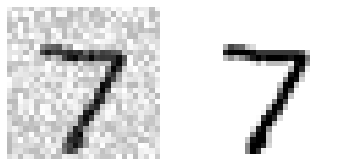

In [140]:
# don't look at the test set for an actual project but
# here is the first image in the test set with its target
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
plt.show()

Now let's train the classifier to clean up the image:

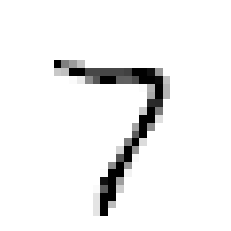

In [139]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()

It looks pretty good :)